In [ ]:
%pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.9 MB/s eta 0:00:00


In [2]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", None)

In [3]:
# Load preprocessed training data

data_path = "./Data/training_data.csv" 
df = pd.read_csv(data_path)
df["date"] = pd.to_datetime(df["date"])

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())

Shape: (5832737, 17)
Columns: ['item_id', 'date', 'demand', 'lag_1', 'lag_7', 'lag_28', 'rolling_mean_7', 'rolling_mean_28', 'rolling_std_7', 'rolling_std_28', 'diff_1', 'diff_7', 'wday', 'month', 'year', 'is_weekend', 'is_holiday']
            item_id       date  demand  lag_1  lag_7  lag_28  rolling_mean_7  \
0  FOODS_1_001_CA_1 2011-02-26       2    4.0    1.0     3.0        1.857143   
1  FOODS_1_001_CA_1 2011-02-27       2    2.0    2.0     0.0        2.000000   
2  FOODS_1_001_CA_1 2011-02-28       0    2.0    0.0     0.0        2.000000   
3  FOODS_1_001_CA_1 2011-03-01       2    0.0    2.0     1.0        2.000000   
4  FOODS_1_001_CA_1 2011-03-02       1    2.0    2.0     4.0        2.000000   

   rolling_mean_28  rolling_std_7  rolling_std_28  diff_1  diff_7  wday  \
0         1.392857       1.214986        1.286375     2.0    -1.0     1   
1         1.357143       1.154701        1.253566    -2.0     1.0     2   
2         1.428571       1.154701        1.230133     0.0    

In [4]:
# Train/Test split by last 28 days

last_date = df["date"].max()
test_start = last_date - pd.Timedelta(days=27)

print("Last date in data:", last_date)
print("Test start date:", test_start)

train_mask = df["date"] < test_start
test_mask = df["date"] >= test_start

train_df = df[train_mask].copy()
test_df = df[test_mask].copy()

print("\nTrain date range:", train_df["date"].min(), "→", train_df["date"].max())
print("Test date range :", test_df["date"].min(), "→", test_df["date"].max())
print("Train size:", len(train_df), "rows")
print("Test size :", len(test_df), "rows")
print("Unique test days:", test_df["date"].nunique())

Last date in data: 2016-05-22 00:00:00
Test start date: 2016-04-25 00:00:00

Train date range: 2011-02-26 00:00:00 → 2016-04-24 00:00:00
Test date range : 2016-04-25 00:00:00 → 2016-05-22 00:00:00
Train size: 5747365 rows
Test size : 85372 rows
Unique test days: 28


In [5]:
# Define feature sets and target

target_col = "demand"

# Baseline Model:
features_baseline= [
    "wday", "month", "year",
    "is_weekend", "is_holiday"
]

# Lag Model : add lag  
features_lag = [
    "lag_1", "lag_7", "lag_28",
    "wday", "month", "year",
    "is_weekend", "is_holiday"
]

# Enhanced Model: lag + enhanced features (rolling + diff + calendar)  
features_enhanced = [
    "lag_1", "lag_7", "lag_28",
    "rolling_mean_7", "rolling_mean_28",
    "rolling_std_7", "rolling_std_28",
    "diff_1", "diff_7",
    "wday", "month", "year",
    "is_weekend", "is_holiday"
]

print("Baseline Model features (calendar-only):", features_baseline)
print("Lag Model features (lag-only):", features_lag)
print("Enhanced Model features (enhanced):", features_enhanced)

all_features = sorted(list(set(features_baseline+ features_lag + features_enhanced)))

print("\nMissing values in train_df (any feature used):")
print(train_df[all_features + [target_col]].isna().sum())
print("\nMissing values in test_df (any feature used):")
print(test_df[all_features + [target_col]].isna().sum())

Baseline Model features (calendar-only): ['wday', 'month', 'year', 'is_weekend', 'is_holiday']
Lag Model features (lag-only): ['lag_1', 'lag_7', 'lag_28', 'wday', 'month', 'year', 'is_weekend', 'is_holiday']
Enhanced Model features (enhanced): ['lag_1', 'lag_7', 'lag_28', 'rolling_mean_7', 'rolling_mean_28', 'rolling_std_7', 'rolling_std_28', 'diff_1', 'diff_7', 'wday', 'month', 'year', 'is_weekend', 'is_holiday']

Missing values in train_df (any feature used):
diff_1             0
diff_7             0
is_holiday         0
is_weekend         0
lag_1              0
lag_28             0
lag_7              0
month              0
rolling_mean_28    0
rolling_mean_7     0
rolling_std_28     0
rolling_std_7      0
wday               0
year               0
demand             0
dtype: int64

Missing values in test_df (any feature used):
diff_1             0
diff_7             0
is_holiday         0
is_weekend         0
lag_1              0
lag_28             0
lag_7              0
month       

In [6]:
# Cell 5: Build X, y for all models

X_train_baseline = train_df[features_baseline].values
X_test_baseline = test_df[features_baseline].values

X_train_lag = train_df[features_lag].values
X_test_lag = test_df[features_lag].values

X_train_enhanced = train_df[features_enhanced].values   
X_test_enhanced = test_df[features_enhanced].values     

y_train = train_df[target_col].values
y_test = test_df[target_col].values

print("X_train_baseline shape:", X_train_baseline.shape)
print("X_test_baseline shape :", X_test_baseline.shape)
print("X_train_lag shape:", X_train_lag.shape)
print("X_test_lag shape :", X_test_lag.shape)
print("X_train_enhanced shape:", X_train_enhanced.shape)   
print("X_test_enhanced shape :", X_test_enhanced.shape)    
print("y_train shape  :", y_train.shape)
print("y_test shape   :", y_test.shape)

X_train_baseline shape: (5747365, 5)
X_test_baseline shape : (85372, 5)
X_train_lag shape: (5747365, 8)
X_test_lag shape : (85372, 8)
X_train_enhanced shape: (5747365, 14)
X_test_enhanced shape : (85372, 14)
y_train shape  : (5747365,)
y_test shape   : (85372,)


In [7]:
# Train Baseline Model (calendar-only XGBoost)

model_baseline = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

print("Training Baseline Model (calendar-only)...")
model_baseline.fit(X_train_baseline, y_train)

y_pred_baseline = model_baseline.predict(X_test_baseline)

rmse_baseline = mean_squared_error(y_test, y_pred_baseline, squared=False)
print(f"\nBaseline Model RMSE (calendar-only, last 28 days): {rmse_baseline:.4f}")

Training Baseline Model (calendar-only)...

Baseline Model RMSE (calendar-only, last 28 days): 3.5885


/opt/anaconda3/envs/demand_forecast_cpu/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [8]:
# Train Lag Model (lag XGBoost) 

model_lag = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

print("Training Lag Model...")
model_lag.fit(X_train_lag, y_train)

y_pred_lag = model_lag.predict(X_test_lag)

rmse_lag = mean_squared_error(y_test, y_pred_lag, squared=False)
print(f"\nLag Model RMSE (lag-only, last 28 days): {rmse_lag:.4f}")

Training Lag Model...

Lag Model RMSE (lag-only, last 28 days): 2.2122


/opt/anaconda3/envs/demand_forecast_cpu/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [9]:
# Train Enhanced Model (lag + enhanced features XGBoost) 

model_enhanced = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

print("Training Enhanced Model (lag + enhanced features)...")
model_enhanced.fit(X_train_enhanced, y_train)

y_pred_enhanced = model_enhanced.predict(X_test_enhanced)

rmse_enhanced = mean_squared_error(y_test, y_pred_enhanced, squared=False)
print(f"\nEnhanced Model RMSE (enhanced, last 28 days): {rmse_enhanced:.4f}")

Training Enhanced Model (lag + enhanced features)...

Enhanced Model RMSE (enhanced, last 28 days): 2.0352


/opt/anaconda3/envs/demand_forecast_cpu/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [10]:
# Attach predictions to test_df for further analysis  

results_df = test_df.copy()
results_df["pred_baseline"] = y_pred_baseline
results_df["pred_lag"] = y_pred_lag
results_df["pred_enhanced"] = y_pred_enhanced  

print(results_df.head())

               item_id       date  demand  lag_1  lag_7  lag_28  \
1885  FOODS_1_001_CA_1 2016-04-25       2    0.0    4.0     2.0   
1886  FOODS_1_001_CA_1 2016-04-26       0    2.0    1.0     1.0   
1887  FOODS_1_001_CA_1 2016-04-27       0    0.0    1.0     1.0   
1888  FOODS_1_001_CA_1 2016-04-28       0    0.0    0.0     0.0   
1889  FOODS_1_001_CA_1 2016-04-29       0    0.0    1.0     4.0   

      rolling_mean_7  rolling_mean_28  rolling_std_7  rolling_std_28  diff_1  \
1885        1.142857         1.178571       1.345185        1.278123    -1.0   
1886        0.857143         1.178571       0.690066        1.278123     2.0   
1887        0.714286         1.142857       0.755929        1.297127    -2.0   
1888        0.571429         1.107143       0.786796        1.314852     0.0   
1889        0.571429         1.107143       0.786796        1.314852     0.0   

      diff_7  wday  month  year  is_weekend  is_holiday  pred_baseline  \
1885     4.0     3      4  2016           

                       Model  RMSE_last_28_days
0   Baseline (calendar-only)           3.588455
1                  Lag (lag)           2.212241
2  Enhanced (lag + enhanced)           2.035240


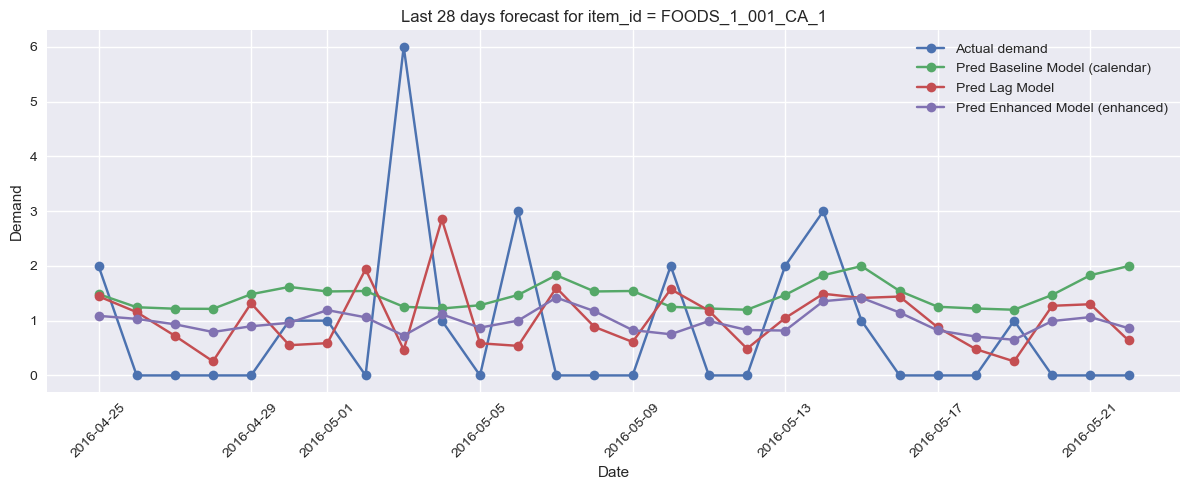

In [11]:

# Compare RMSE of Baseline Model vs Lag Model vs Enhanced Model 

rmse_summary = pd.DataFrame({
    "Model": [
        "Baseline (calendar-only)",
        "Lag (lag)",
        "Enhanced (lag + enhanced)"
    ],
    "RMSE_last_28_days": [rmse_baseline, rmse_lag, rmse_enhanced]
})

print(rmse_summary)

# Plot actual vs predicted for one example item

example_item = results_df["item_id"].iloc[0]

plot_df = results_df[results_df["item_id"] == example_item].sort_values("date")

plt.figure(figsize=(12, 5))
plt.plot(plot_df["date"], plot_df["demand"], marker="o", label="Actual demand")
plt.plot(plot_df["date"], plot_df["pred_baseline"], marker="o", label="Pred Baseline Model (calendar)")
plt.plot(plot_df["date"], plot_df["pred_lag"], marker="o", label="Pred Lag Model")
plt.plot(plot_df["date"], plot_df["pred_enhanced"], marker="o", label="Pred Enhanced Model (enhanced)")

plt.title(f"Last 28 days forecast for item_id = {example_item}")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

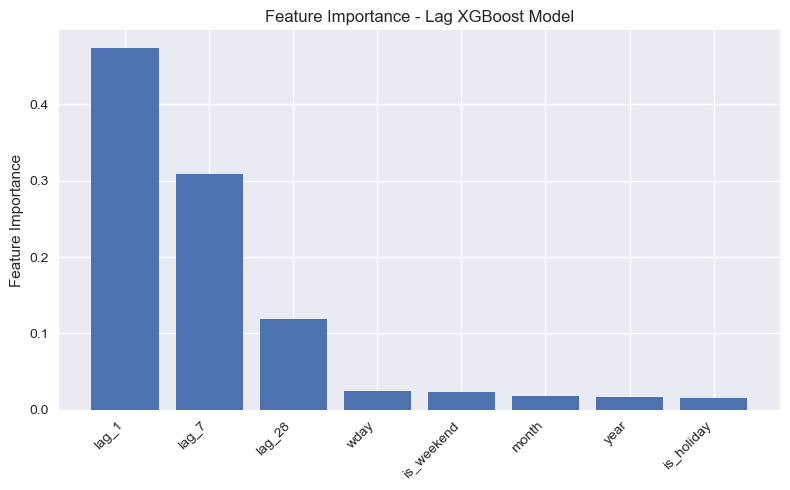

In [14]:

importance_B = model_lag.feature_importances_   

sorted_idx_B = np.argsort(importance_B)[::-1]

plt.figure(figsize=(8, 5))
plt.bar(
    np.array(features_lag)[sorted_idx_B],
    importance_B[sorted_idx_B]
)
plt.ylabel("Feature Importance")
plt.title("Feature Importance - Lag XGBoost Model")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

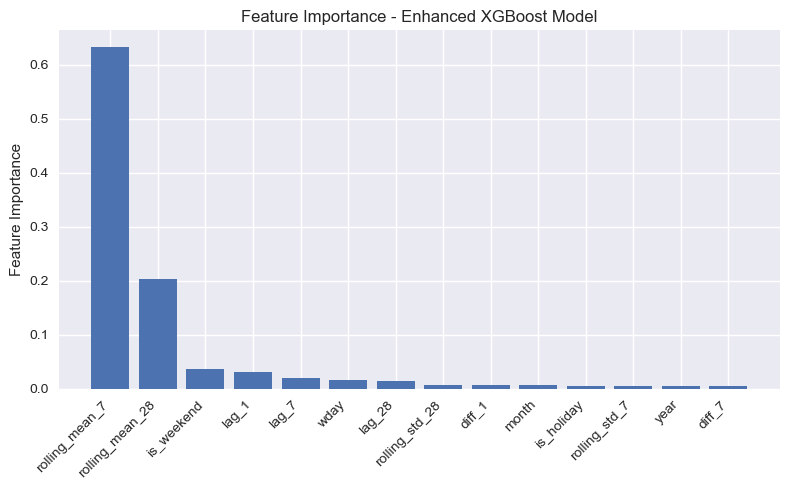

In [12]:
feature_importance = model_enhanced.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(8, 5))
plt.bar(
    np.array(features_enhanced)[sorted_idx],
    feature_importance[sorted_idx]
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Feature Importance")
plt.title("Feature Importance - Enhanced XGBoost Model")
plt.tight_layout()
plt.show()